# Стратегия взаимодействия с клиентами в сети фитнес-центров «Культурист-датасаентист»
## Оглавление
* [Шаг 1. Загрузка данных и изучение общей информации](#h1_1)
* [Шаг 2. Проведение исследовательского анализа данных (EDA)](#h1_2)
* [Шаг 3. Построение модели прогнозирования оттока клиентов](#h1_3)
* [Шаг 4. Кластеризация клиентов](#h1_4)
* [Шаг 5. Выводы и базовые рекомендации по работе с клиентами](#h1_5)

## Описание проекта
Исходные данные: сведения о клиентах фитнес-центра, информация из журнала посещений, о покупках и текущем статусе абонемента клиента.

Цели проекта:
* спрогнозировать вероятность оттока каждого клиента фитнес-центра;
* выявить основные факторы, влияющие на отток клиентов, и сформировать портреты лояльных клиентов и склонных к оттоку;
* дать рекомендации по повышению качества работы с клиентами и снижению оттока.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings

# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

#отключение предупреждений
warnings.filterwarnings('ignore')

# фунция для обучения моделей и расчета метрик accuracy, precision и recall
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('* Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('* Precision: {:.2f}'.format(precision_score (y_test, y_pred)))
    print('* Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('* F1: {:.2f}'.format(f1_score(y_test, y_pred)))

## Шаг 1. Загрузка данных и изучение общей информации<a class="anchor" id="h1_1"></a>


In [2]:
# Открытие файла и создание датафрейма
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')

Посмотрим общую информацию и примеры данных:

In [3]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В исходном датасете достаточно много записей. Пропущенных значений нет. Типы данных можно оставить без изменения.

Для удобства последующей работы переименуем названия колонок в нижний регистр:

In [4]:
df.columns = df.columns.str.lower()

### Выводы по шагу 1
1. Данные загружены в датафрейм. В исходном датасете достаточно много записей.
1. Пропущенных значений в данных нет. 
1. Типы данных решено оставить без изменения.
1. Названия колонок переименованы в нижний регистр.

## Шаг 2. Проведение исследовательского анализа данных (EDA)<a class="anchor" id="h1_2"></a>
Для начала посмотрим подробнее на датасет, посмотрим средние значения и стандартные отклонения.

In [5]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Каких-то явных проблем в данных не видно.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [6]:
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На основе этих данных можно сделать выводы по средним значениям параметров:
* `gender`: доли мужчин и женщин в обеих группах одинаковы
* `near_location`: доля живущих рядом среди ушедших чуть меньше, чем среди оставшихся
* `partner`: доля пришедших из компании-партнера на 50% больше среди оставшихся клиентов
* `promo_friends`: доля пришедщих по акции "Приведи друга" в 2 раза больше среди оставшихся клиентов
* `phone`: доли клиентов с контактным телефоном и без в обеих группах одинаковы
* `contract_period`: cредняя длительность абонемента в 3 раза выше среди оставшихся клиентов.
* `group_visits`: доля ходящих на групповые занятия почти в 2 раза больше среди оставшихся клиентов
* `age`: средний возраст оставшихся клиентов на 3 года больше, чем ушедших
* `avg_additional_charges_total`: средняя выручка от других услуг центра на 30% выше среди оставшихся клиентов
* `month_to_end_contract`: число месяцев до окончания абонемента в 3 раза выше среди оставшихся клиентов
* `lifetime`: время с момента первого обращения почти в 5 раз выше среди оставшихся клиентов
* `avg_class_frequency_total`: средняя частота посещений в неделю за все время с начала действия абонемента на 30% выше среди оставшихся клиентов
* `avg_class_frequency_current_month`: средняя частота посещений в неделю за предыдущий месяц в 2 раза выше среди оставшихся клиентов

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Разделим признаки на бинарные (те, у которых может быть только два значения) и те, у которых может быть больше двух значений. Бинарные признаки можно отобразить наглядно в виде долей на одной столбчатой диаграмме.

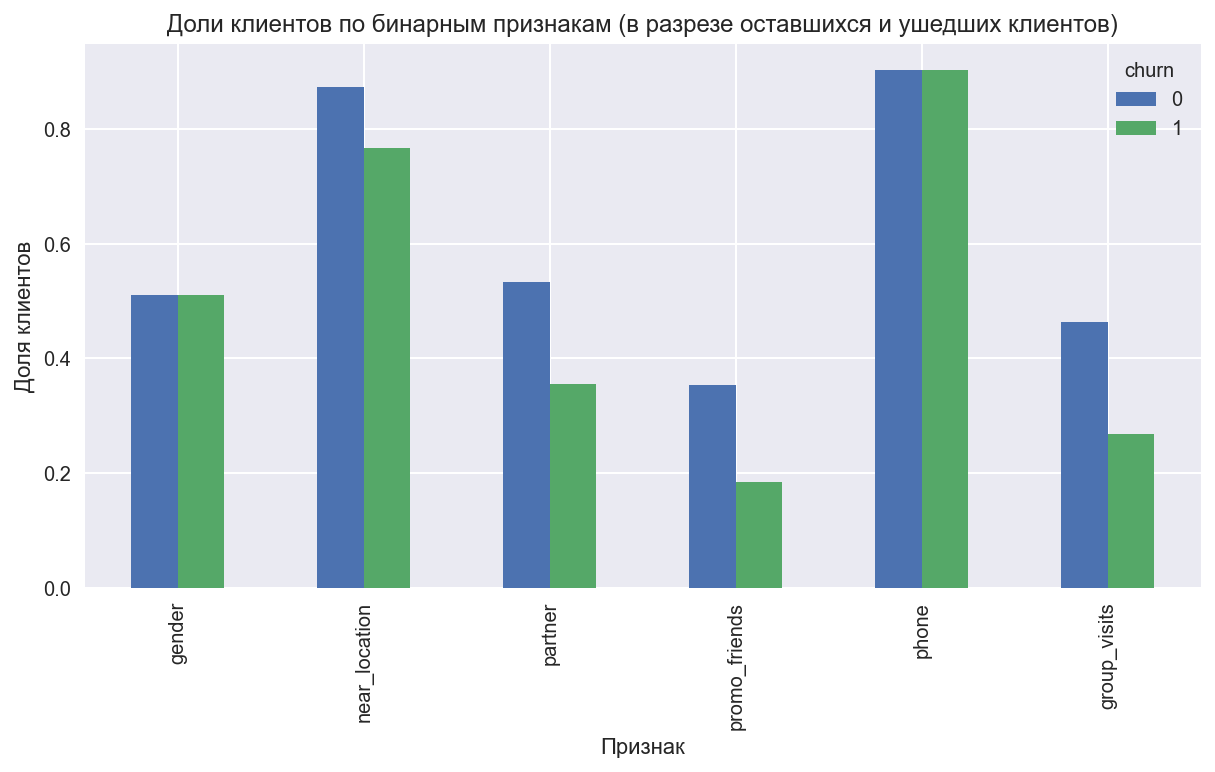

In [7]:
binary_features = ['gender','near_location','partner','promo_friends','phone','group_visits']

with plt.style.context('seaborn'):
    df.groupby('churn')[binary_features].agg('mean').T.plot(kind='bar', stacked=False, figsize=(10, 5))
    plt.title('Доли клиентов по бинарным признакам (в разрезе оставшихся и ушедших клиентов)')
    plt.xlabel('Признак')
    plt.ylabel('Доля клиентов')    
    plt.show()

Данная диаграмма наглядно показывает выводы, сделанные ранее по средним значениям.

Для тех признаков, у которых может быть больше двух значений, построим гистограммы/кривые плотностей распределений.

Количество тех, кто ушел в отток:  1061
Количество тех, кто остался:  2939


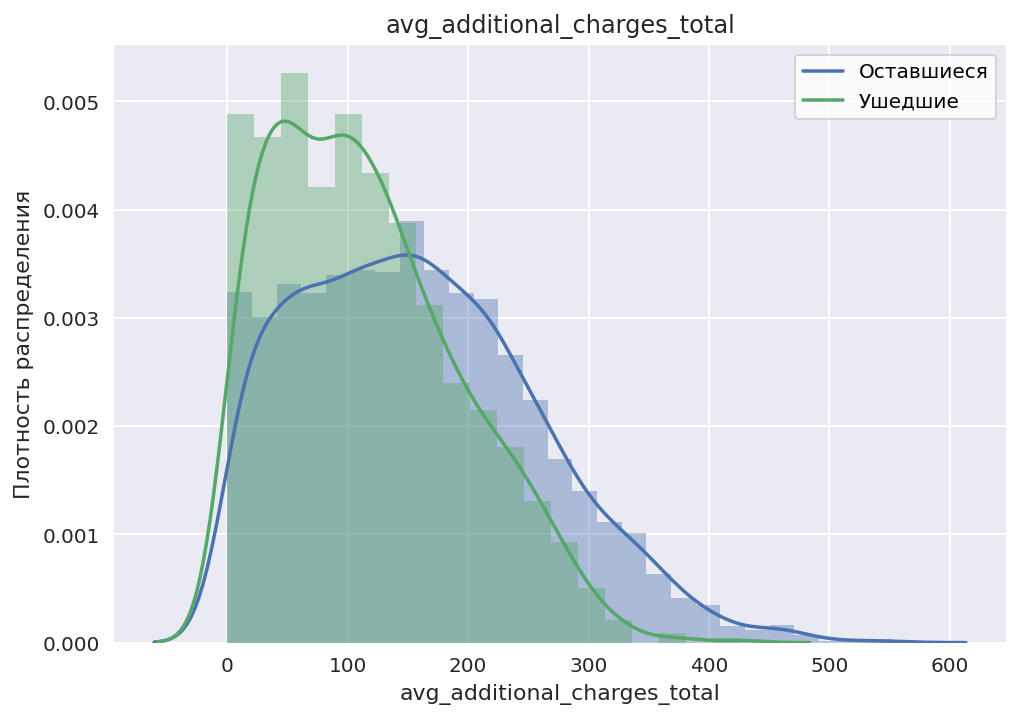

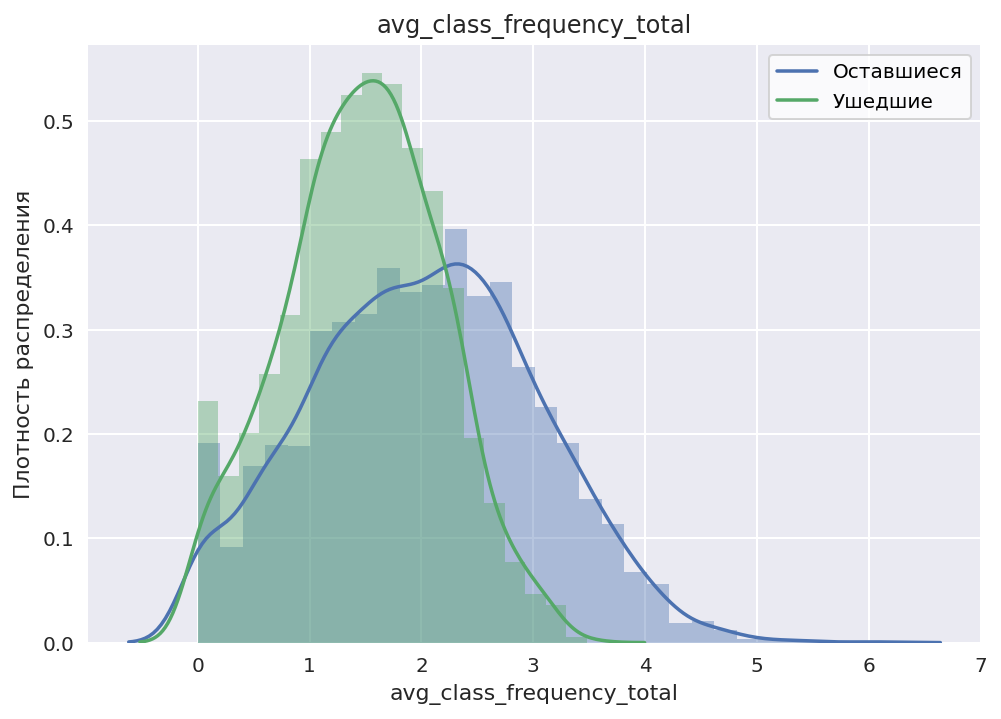

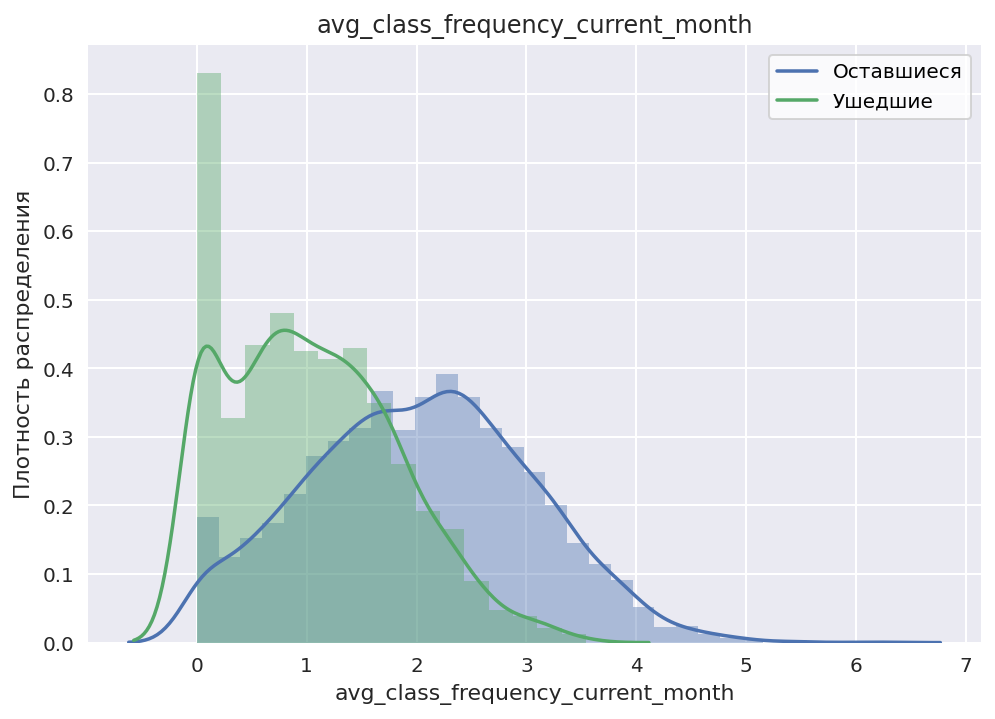

In [8]:
# Создание отдельных датафреймов с теми, кто ушёл (отток) и тех, кто остался (не попали в отток)
churn = df[df['churn'] == 1]
remain = df[df['churn'] == 0]
print('Количество тех, кто ушел в отток: ',len(churn))
print('Количество тех, кто остался: ',len(remain))

num_features = ['avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']

# Построение гистограмм
for col in num_features:
    with plt.style.context('seaborn'):
        sns.distplot(remain[col])
        sns.distplot(churn[col])
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(col)
    plt.legend(labels)
    plt.xlabel(col)
    plt.ylabel('Плотность распределения')
    plt.show()

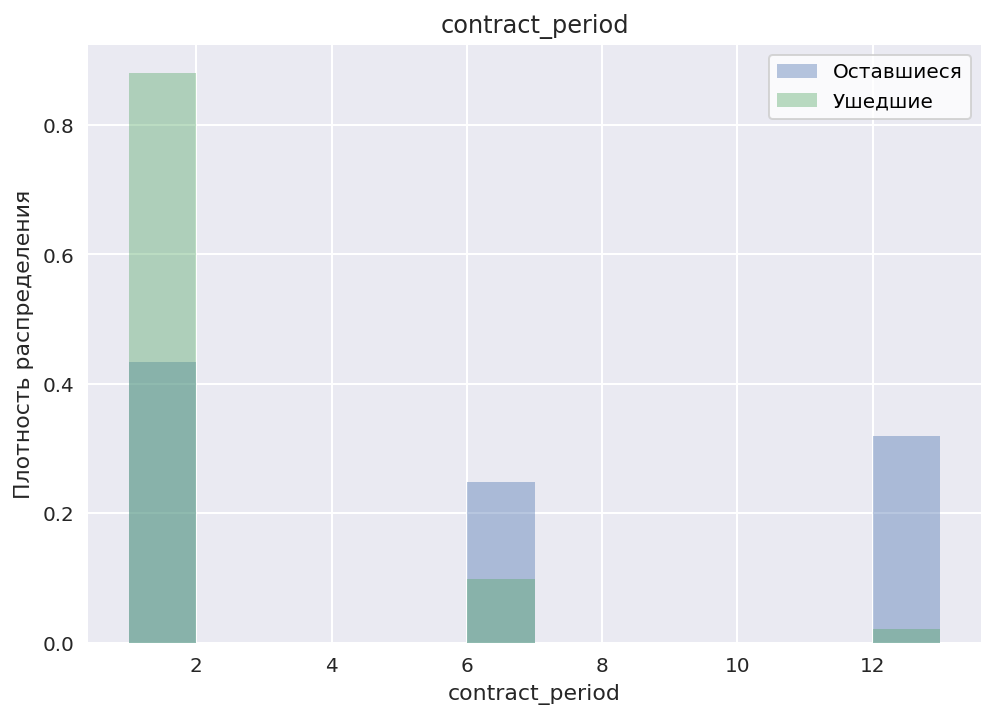

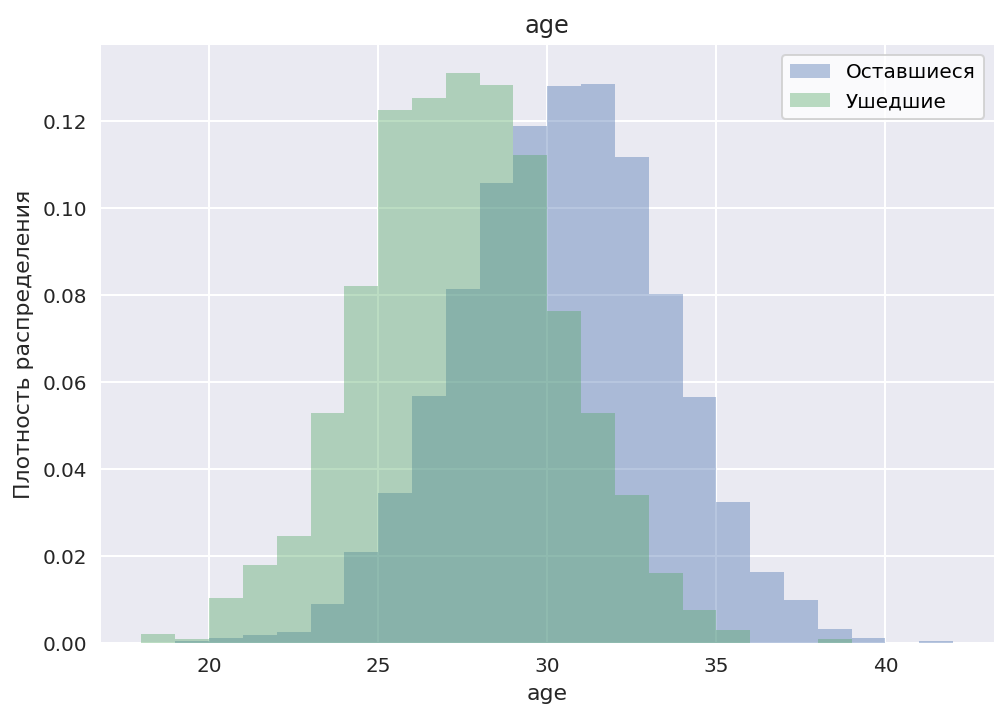

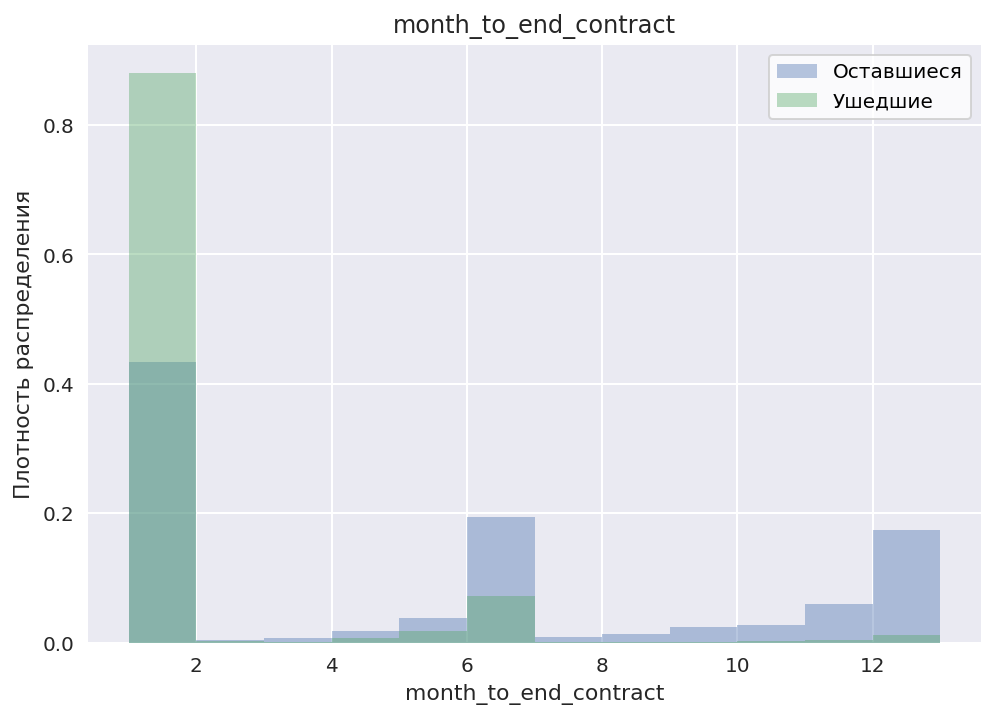

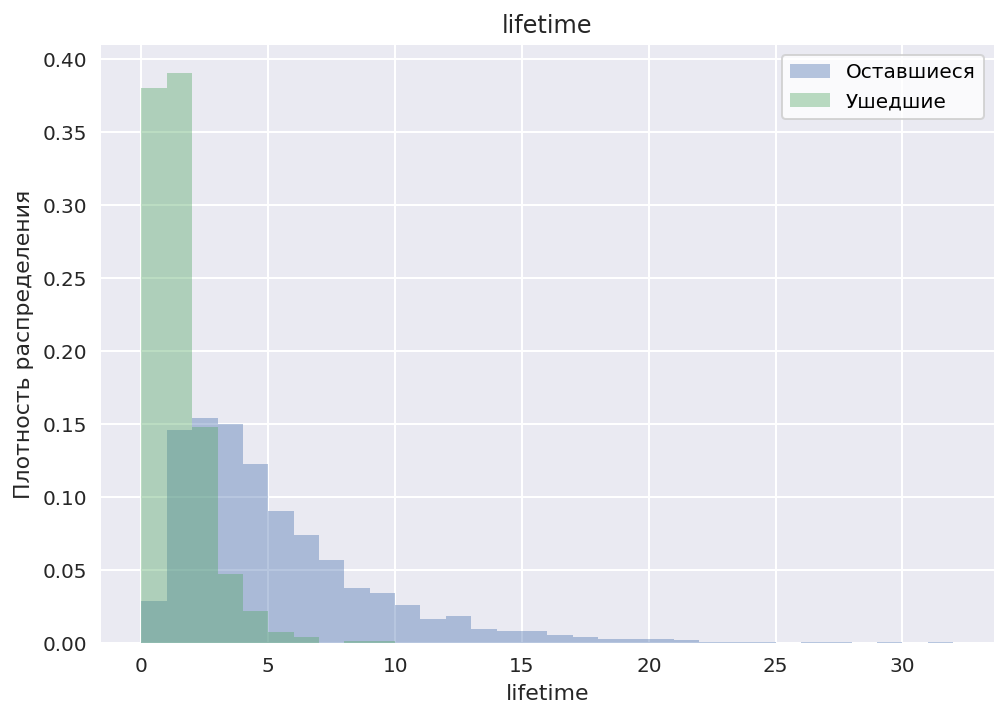

In [9]:
num_features = ['contract_period','age','month_to_end_contract','lifetime']

# Построение гистограмм
for col in num_features:
    min_value = int(min(df[col]))    
    max_value = int(max(df[col]))
    with plt.style.context('seaborn'):
        sns.distplot(df[df['churn']==0][col], kde=False, norm_hist=True, bins = range(min_value, max_value+2), label='0')
        sns.distplot(df[df['churn']==1][col], kde=False, norm_hist=True, bins = range(min_value, max_value+2), label='1')
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(col)
    plt.legend(labels)
    plt.xlabel(col)
    plt.ylabel('Плотность распределения')
    plt.show()


Выводы по сравнению гистограмм тех, кто ушел в отток и тех, кто остался:
1. contract_period: по гистограмме видно, что оставшиеся клиенты - это в основном те, кто покупает абонементы на 6 и 12 месяцев. А ушедшие - в большинстве случаев те, кто покупал абонемент на 1 месяц.
1. age: здесь еще раз наглядно видно, что средний возраст ушедших клиентов на 3-4 года меньше, чем у оставшихся. Также среди оставшихся есть большой всплеск в 30 лет.
1. avg_additional_charges_total: вид гистограмм по данному параметру схож, но действительно оставшиеся клиенты тратят немного больше ушедших. Но возможно это различие по большей части из-за того, что выборка оставшихся в 3 раза больше, чем выборка ушедших
1. month_to_end_contract: характер распределения по данному параметру очень похож на `contract_period`, возможно между ними есть большая корреляция.
1. lifetime: и здесь схож вид гистограмм, но среди оставшихся клиентов время с момента первого обращения значительно выше.
1. avg_class_frequency_total: вид двух гистограмм схож. Наглядно видно, что оставшиеся клиенты ходят чаще
1. avg_class_frequency_current_month: по данном параметру гистограммы схожи с предыдущим параметров. Но среди ушедших клиентов имеется большой всплеск в самом начале. Похоже, что многие клиенты не сходили за месяц даже ни разу. А возможно это совсем новые клиенты, которые не успели еще сходить на тренировку.

Также аномальных значений по гистограммам невидно.

Далее построим матрицу корреляций и отобразим её в виде тепловой карты.

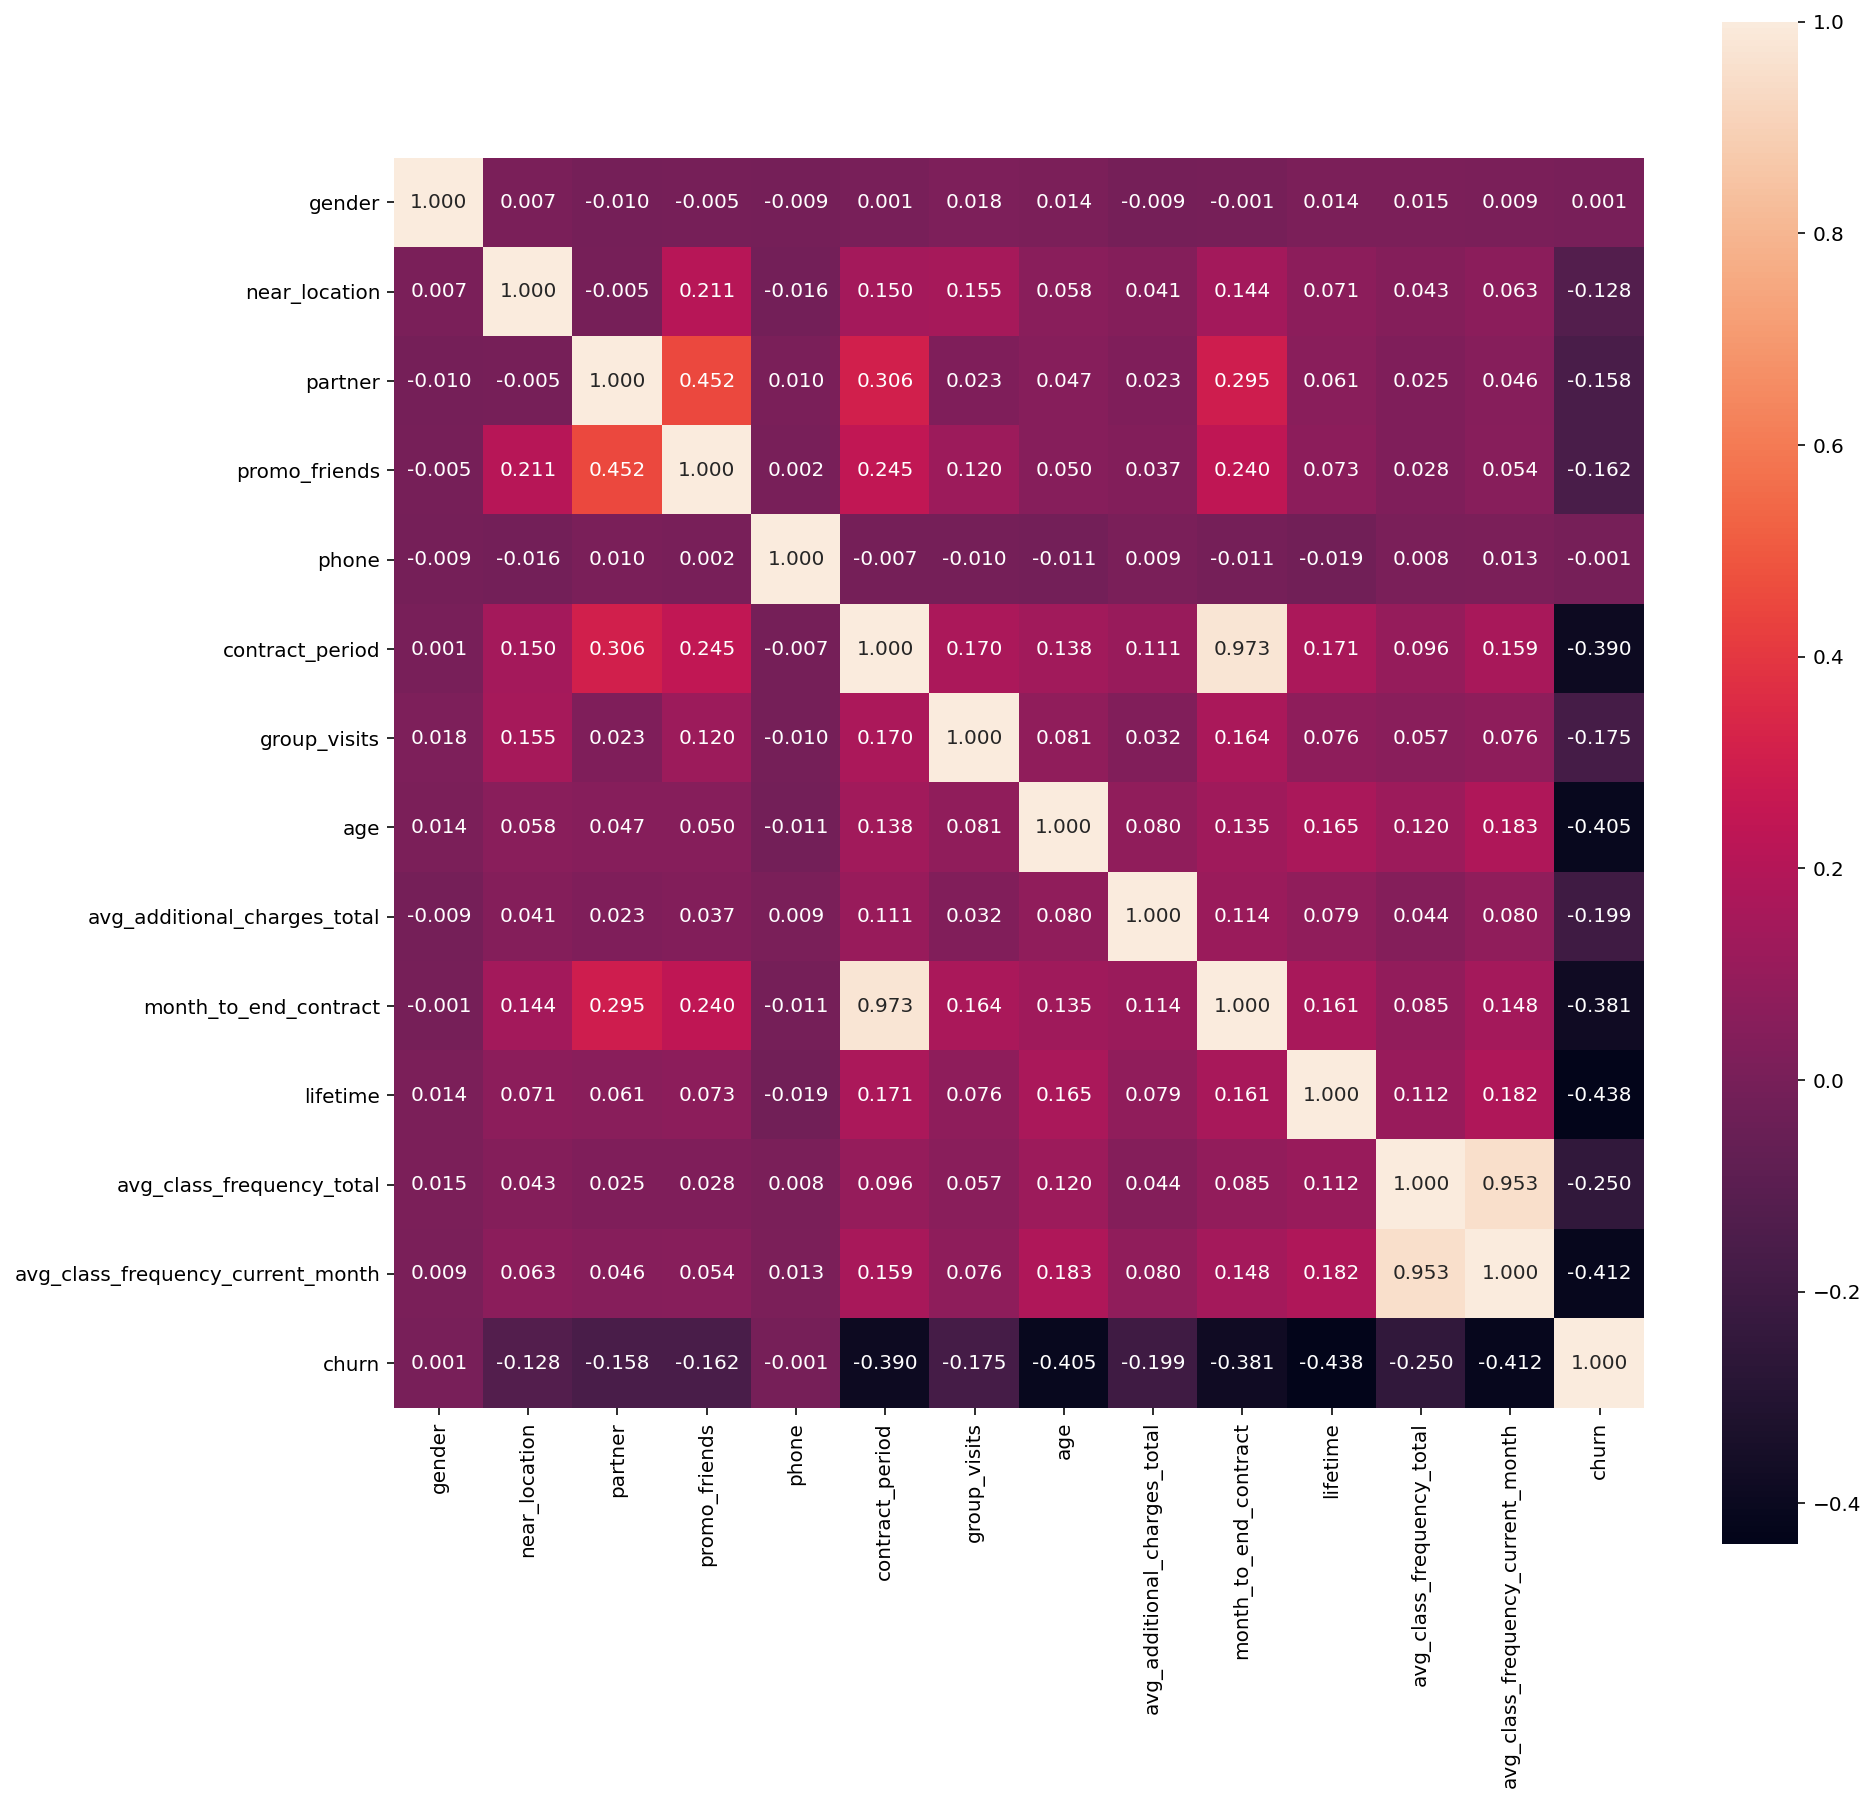

In [10]:
# формирование корреляционной матрицы
corr_m = df.corr()

# вывод матрицы на экран в виде тепловой карты (heatmap)
plt.figure(figsize = (14,14))
sns.heatmap(corr_m, square = True, annot = True, fmt=".3f")
plt.show()

Судя по матрице корреляций, нет признаков, с высокой вероятностью сообщающих, будет уйдет клиент или нет. Зато есть две пары скоррелированных признаков: 
* `contract_period` и `month_to_end_contract`
* `avg_class_frequency_total` и `avg_class_frequency_current_month`

Во избежание мультиколлинеарности, и как результат, получения нерепрезентативных весов и переобученной под эти признаки модель, удалим один из них, например, `month_to_end_contract` и `avg_class_frequency_current_month`.

In [11]:
df = df.drop('month_to_end_contract', axis = 1)
df = df.drop('avg_class_frequency_current_month', axis = 1)

### Выводы по шагу 2
В результате проведения исследовательского анализа данных, было выяснено следующее:
1. Проанализированы средние значения и построены гистограммы признаков в двух группах — тех, кто ушел в отток и тех, кто остался:
	* В обеих группах одинаковы:
		* доли мужчин и женщин
		* доли клиентов с контактным телефоном и без
	* В группе оставшихся значительно больше (в разы):
		* доля пришедщих по акции "Приведи друга" (в 2 раза)
		* cредняя длительность абонемента и число месяцев до окончания абонемента (в 3 раза)
		* доля ходящих на групповые занятия (в 2 раза)
		* время с момента первого обращения (в 5 раз)
		* средняя частота посещений в неделю за предыдущий месяц (в 2 раза)
	* В группе оставшихся больше (до 50%):
		* доля живущих рядом (~ на 15%)
		* доля пришедших из компании-партнера (на 50%)
		* средний возраст клиентов (на 10%, или на 3 года)
		* средняя выручка от других услуг центра (на 30%)
		* средняя частота посещений в неделю за все время с начала действия абонемента (на 30%)
1. Найдены две пары скоррелированных признаков:
    * `contract_period` и `month_to_end_contract`
    * `avg_class_frequency_total` и `avg_class_frequency_current_month`
   
   Решено удалить колонки `month_to_end_contract` и `avg_class_frequency_current_month`.

## Шаг 3. Построение модели прогнозирования оттока клиентов<a class="anchor" id="h1_3"></a>
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого:
* Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
* Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.
* Оценим для обеих моделей на валидационной выборке cледующие метрики:
    * accuracy (доля правильных ответов) - это доля верно угаданных ответов из всех прогнозов.
    * precision (точность) - доля правильных ответов только среди целевого класса.
    * recall (полнота) - показывает, сколько реальных объектов целевого класса удалось обнаружить с помощью модели
    * F1 - сводная метрика, учитывающая баланс между метриками precision и recall.

In [12]:
# Разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# составим список моделей
models = [LogisticRegression(max_iter=1000, random_state=0), RandomForestClassifier(random_state=0)]

for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(max_iter=1000, random_state=0)
* Accuracy: 0.90
* Precision: 0.78
* Recall: 0.81
* F1: 0.80
RandomForestClassifier(random_state=0)
* Accuracy: 0.89
* Precision: 0.78
* Recall: 0.77
* F1: 0.78


В результате расчета метрик на валидационной выборке можно сделать вывод, что обе модели показали себя примерно одинаково. Логистическая регрессия оказалась чуть лучше.

### Выводы по шагу 3
1. Построены модели прогнозирования оттока клиентов двумя способами: логистической регрессией и случайным лесом.
1. По результатам расчета метрик accuracy, precision и recall для обеих моделей на валидационной выборке можно сказать, что обе модели показали себя примерно одинаково: все показатели достаточно высокие.

## Шаг 4. Кластеризация клиентов<a class="anchor" id="h1_4"></a>
Проведем кластеризацию клиентов.

Для начала стандартизируем данные и построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

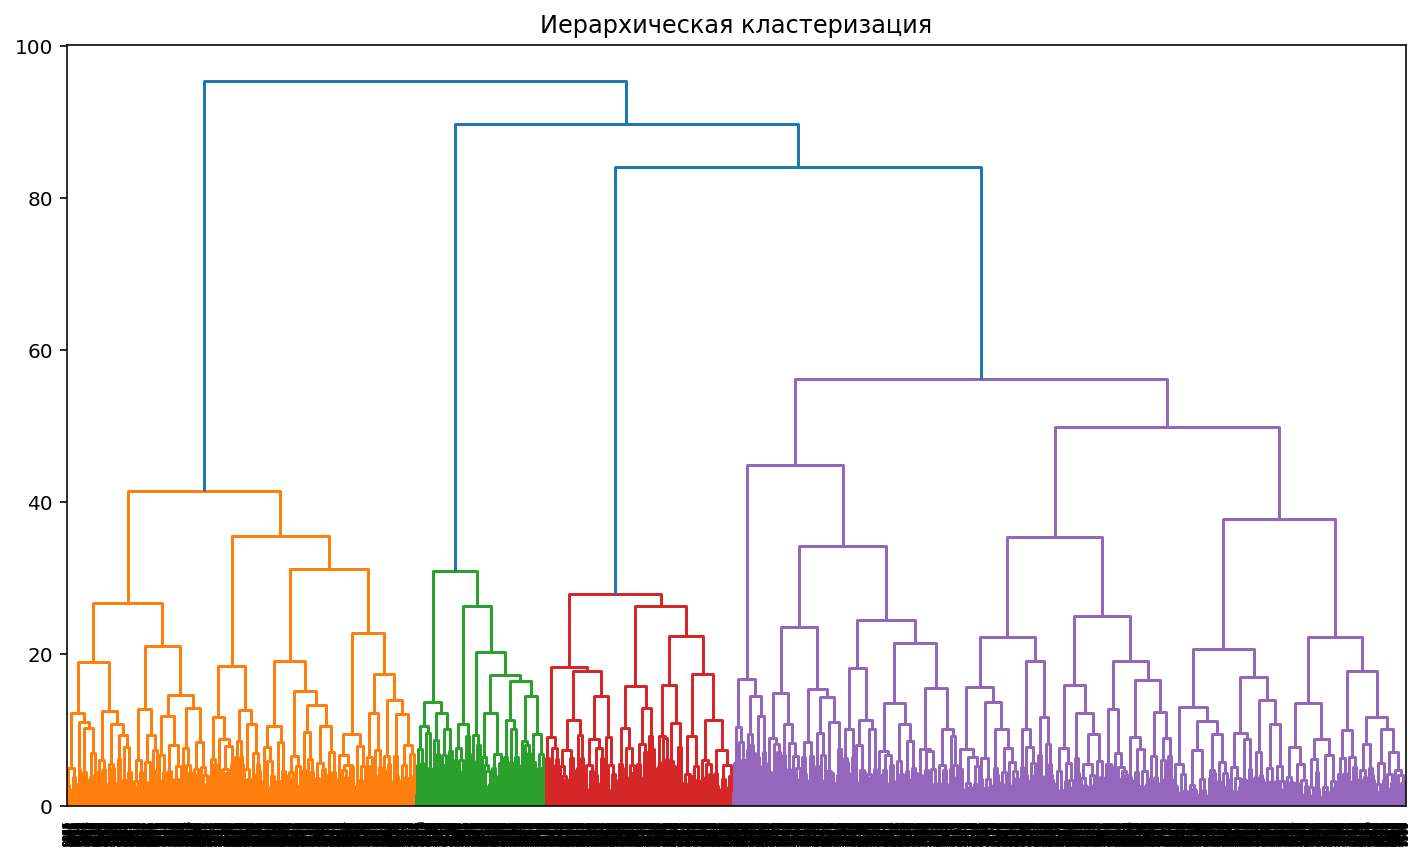

In [13]:
# создадим объект класса StandardScaler и применим его к датафрейму, отбросим столбец с оттоком
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop('churn', axis = 1)) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# В переменной linked сохраняенм таблицу «связок» между объектами. 
linked = linkage(x_sc, method = 'ward')

# Создание и визуализации дендрограммы
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании полученного графика можно предположить, что в данных можно выделить 4 кластера.

Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5, что согласуется с построенной дендрограммой.

In [14]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_client'] = labels

# выводим статистику по средним значениям признаков по кластеру
df.groupby(['cluster_client']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_client,,,,,,,,,,,,
0,0.502683,0.000000,0.490161,0.078712,1.0,3.000000,0.232558,28.708408,137.385192,3.007156,1.768159,0.400716
1,0.486867,0.996248,0.943715,0.883677,1.0,7.660413,0.523452,29.474672,149.409166,4.057223,1.912481,0.117261
2,0.561614,0.996728,0.267176,0.050164,1.0,5.241003,0.533261,30.958561,186.697490,5.778626,2.400164,0.023991
3,0.488806,1.000000,0.223881,0.078358,1.0,2.082090,0.286381,27.584888,116.455656,1.933769,1.466695,0.547575
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Часть параметров похожи и не так различаются между кластерами:
* пол;
* средний возраст.

По следующим параметрам сложно сказать, что они каким-либо образом коррелируют с долей оттока:
* близость к дому: двум кластерам с наибольшей и наименьшей долями клиентов, живущих вблизи дома, соответствуют наибольший процент оттока;
* приход клиента из компаний-партнеров;
* приход клиента по акции "Приведи друга";
* наличие контактного телефона.

Один из сформированных кластеров отличается очень низким оттоком (2-11%, кластера 1 и 2). Ему соответствуют:
* самый высокий показатель посещаемости;
* наибольшее время с момента первого обращения;
* наибольшая сумма трат за дополнительные услуги;
* наибольшая средняя длительность абонемента;
* высокая доля посещаемости групповых занятий.

Кластерам с наибольшей долей оттока (около 40-55%, кластера 0 и 3) соответствуют :
* наименьшие показатели посещаемости;
* наименьшее время со момента первого обращения;
* наименьшие суммы трат за дополнительные услуги;
* наименьшая средняя длительность абонемента;
* наименьшие доли посещаемости групповых занятий.

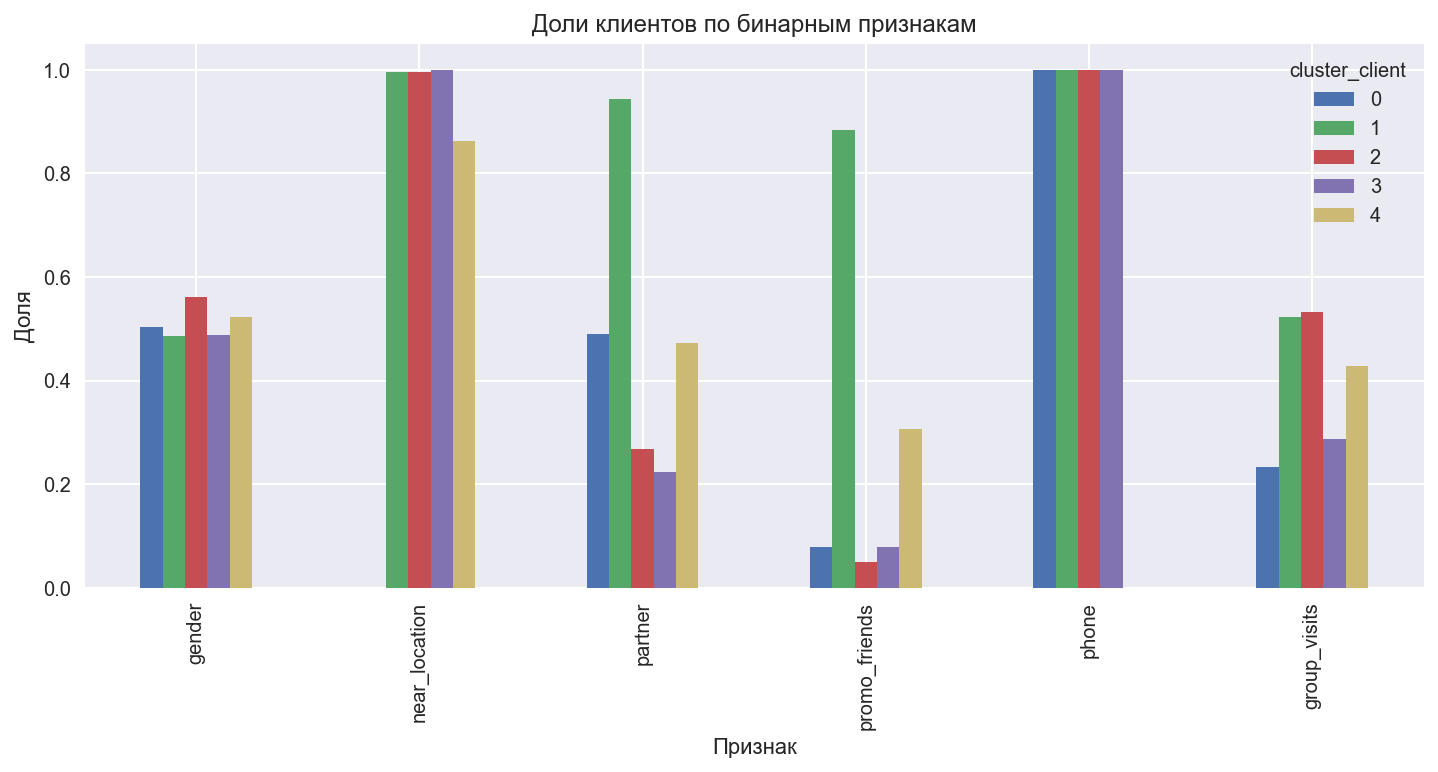

In [15]:
with plt.style.context('seaborn'):
    df.groupby('cluster_client')[binary_features].agg('mean').T.plot(kind='bar', stacked=False, figsize=(12, 5))
    plt.title('Доли клиентов по бинарным признакам')
    plt.xlabel('Признак')
    plt.ylabel('Доля')    
    plt.show()

Полученные гистограммы наглядно показывают выводы, сделанные по данным признакм на основе средних значений.

Далее построим гистограммы плотностей распределений признаков, у которых может быть больше двух значений.

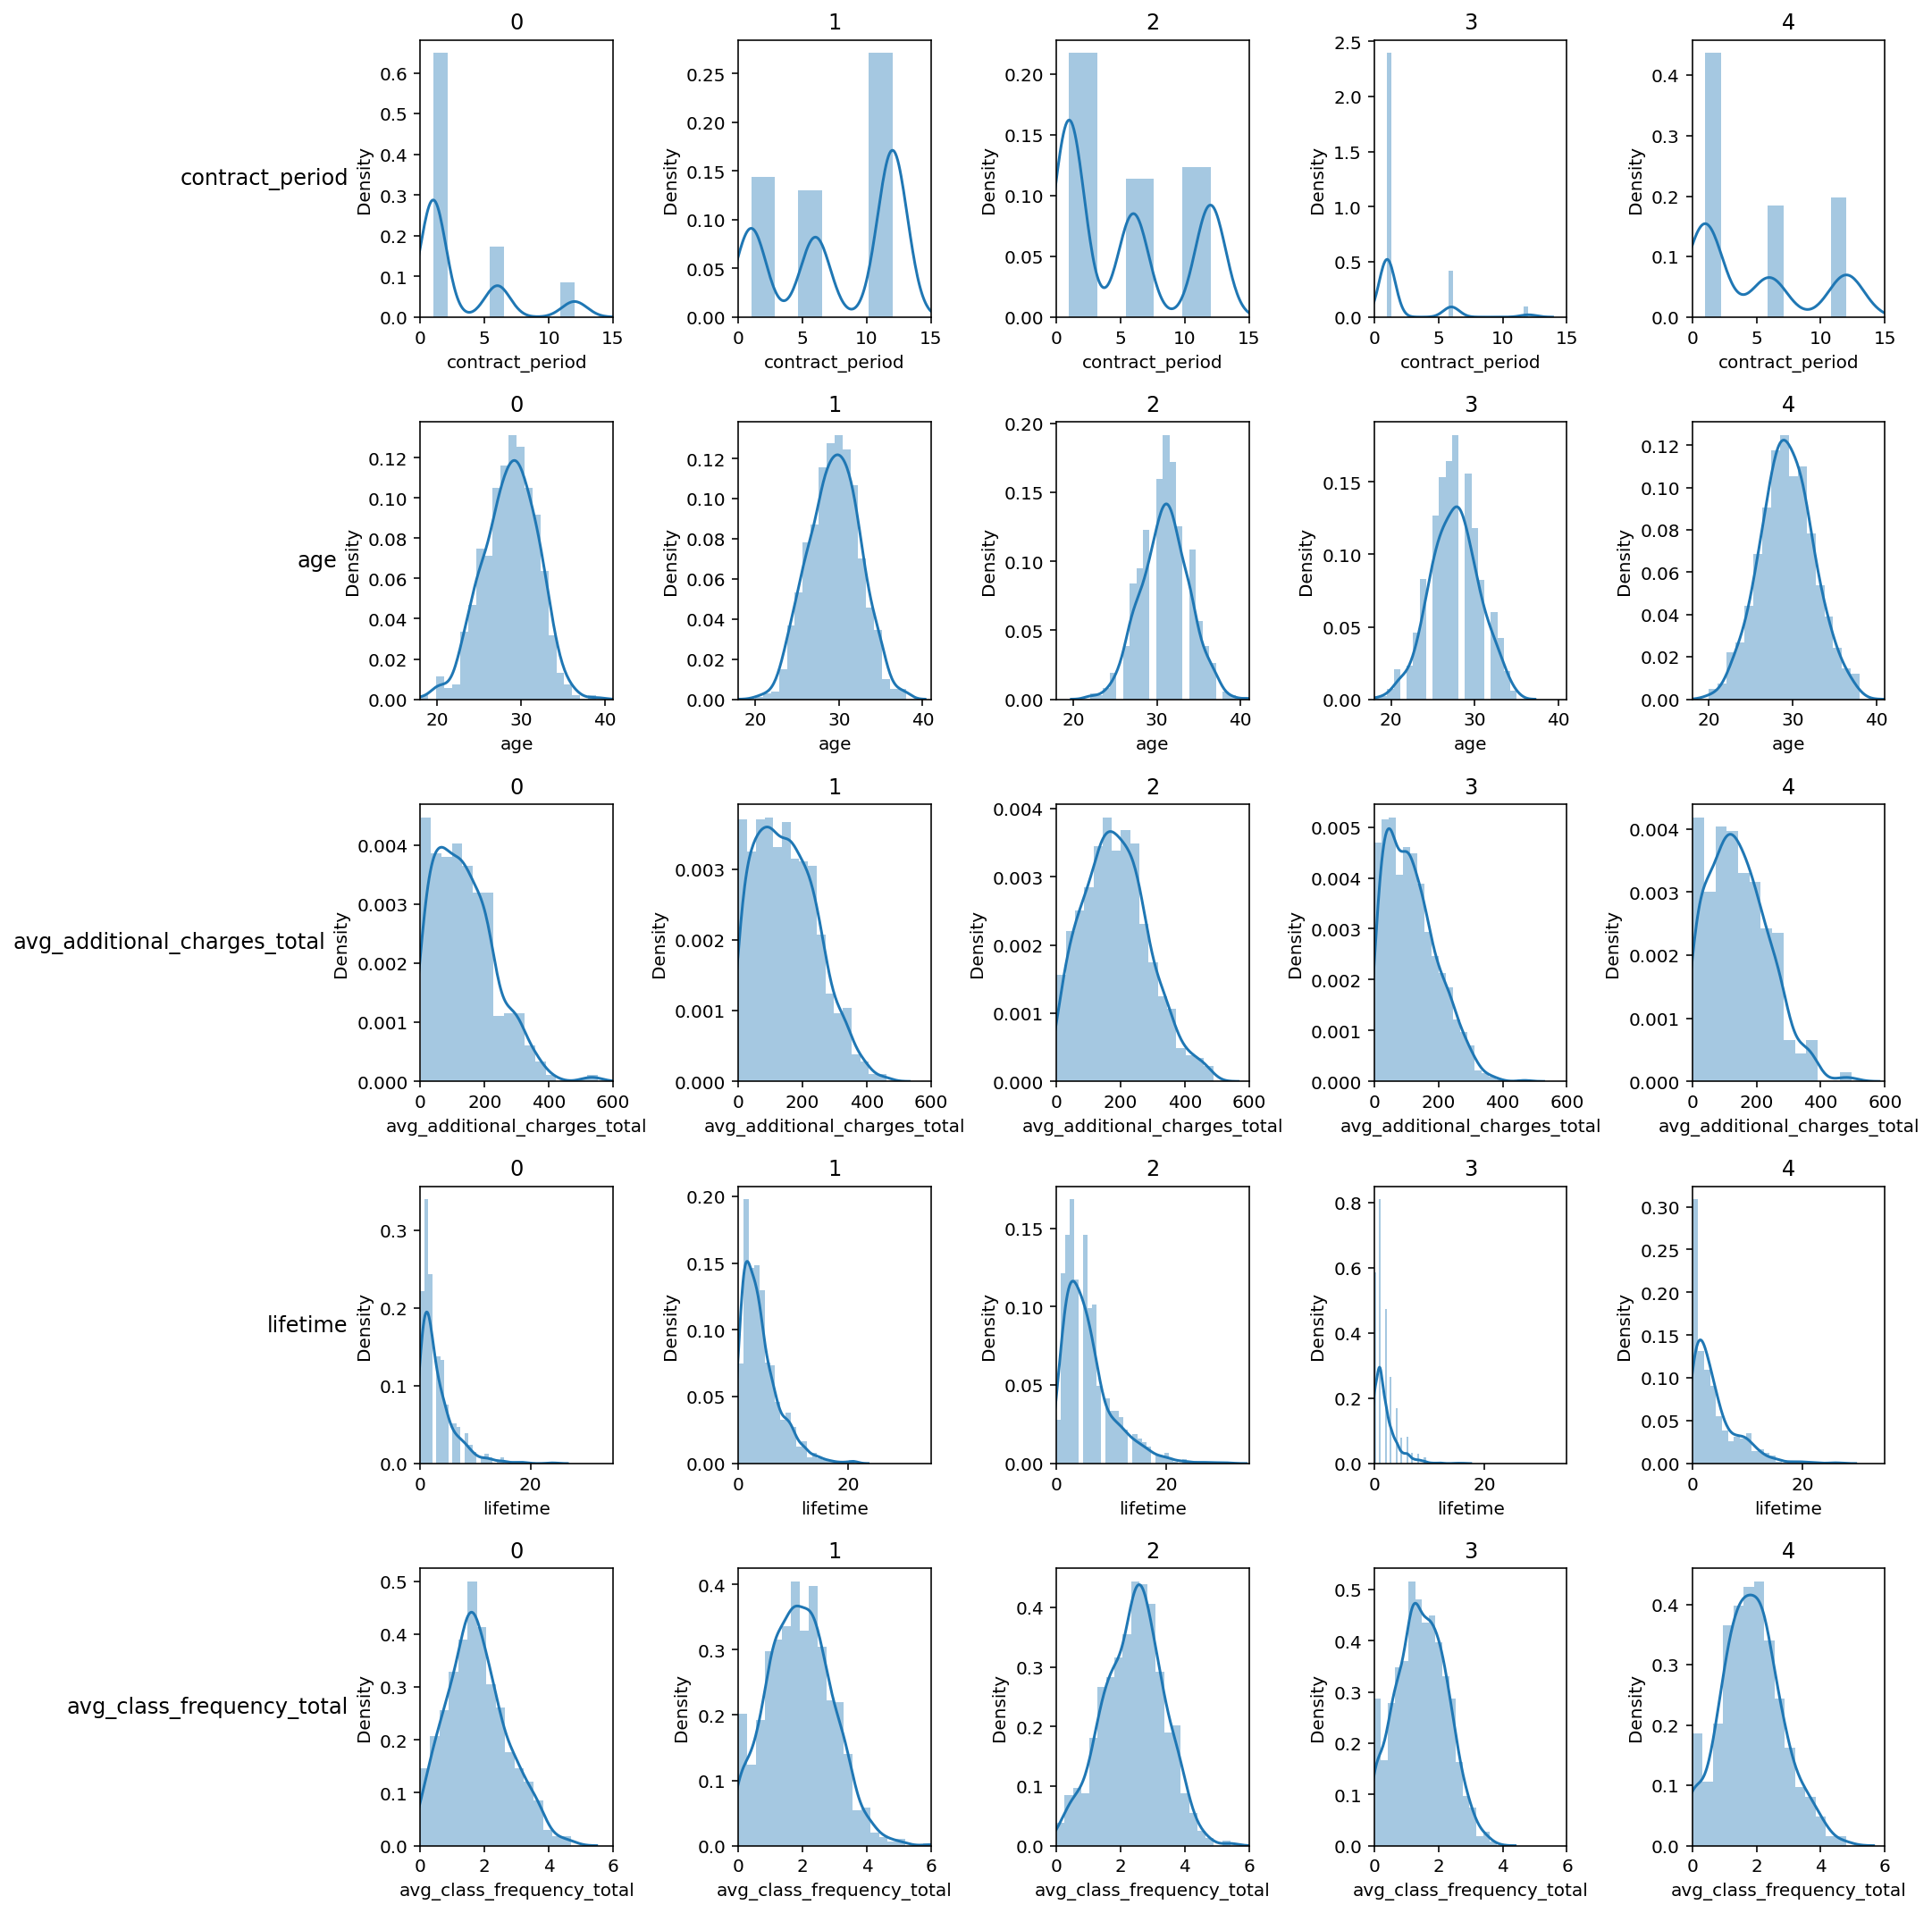

In [16]:
# Формирование списка признаков
num_features = ['contract_period','age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

# Построение гистограмм
fig, axes = plt.subplots(5, 5)
xlimits = [[0, 15],[18, 41],[0, 600],[0, 35],[0, 6]]
i=0
for col in num_features:
    for k in range(5):
        axes[i][k].set_xlim(xlimits[i])
        sns.distplot(df[df['cluster_client']==k][col], ax=axes[i][k])
        axes[i][k].set_title(k)
    i+=1
for ax, row in zip(axes[:,0], num_features):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
plt.show()

На основе данных гистограмм можно сделать следующие выводы:
* Клиенты из двух кластеров с наибольшими долями оттока (кластера 0 и 3) в основном имели абонемент на 1 месяц.
* Клиенты из кластера с наименьшим оттоком (кластера 1 и 2) ходят чаще, причем стабильнее (это видно по узкой гистограмме, т.е. разброс значений у нее наименьший). В основном это старые клиенты.

Для каждого полученного кластера посчитаем долю оттока.

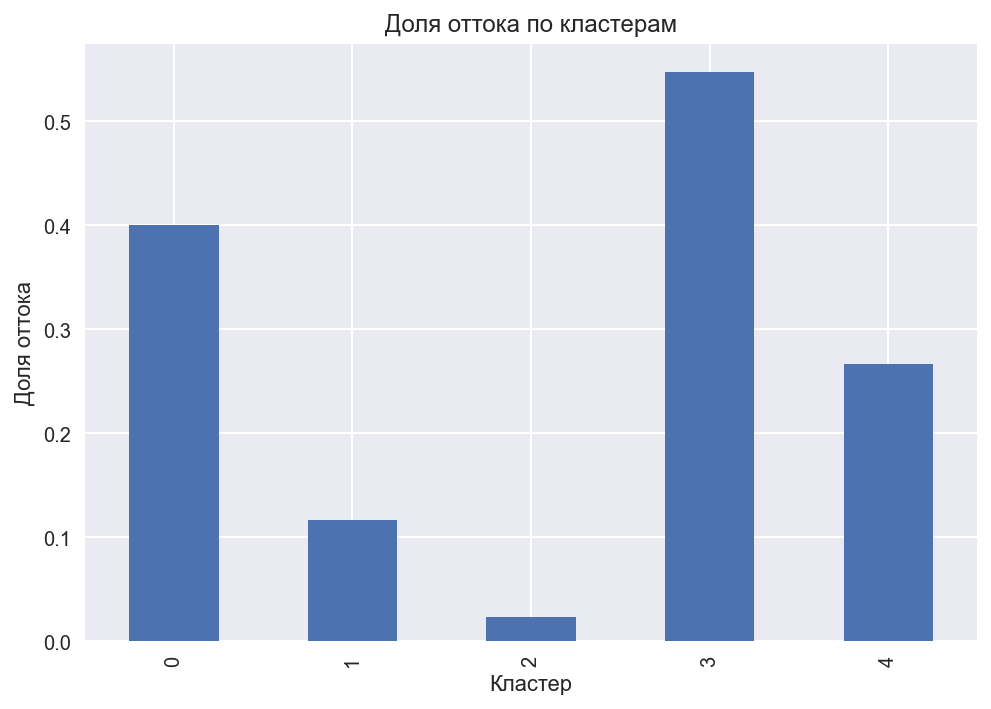

In [17]:
with plt.style.context('seaborn'):
    df.groupby('cluster_client')['churn'].agg('mean').plot(kind='bar')
    plt.title('Доля оттока по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Доля оттока')    
    plt.show()

На диаграмме наглядно видно, что доли оттока сильно разнятся по кластерам. Имеются два кластера с наименьшей долей оттока и два кластера с очень высоким процентом оттока.

### Выводы по шагу 4
На основе проведенного анализа можно сделать следующие выводы:
1. По следующим параметрам никак нельзя сказать, попадет клиент в отток или нет: 
    * пол;
    * средний возраст;
    * близость к дому;
    * приход клиента из компаний-партнеров;
    * приход клиента по акции "Приведи друга";
    * наличие контактного телефона.
1. На основе проведенной кластеризации выявлены группы клиентов с наибольшей и наименьшей долей оттока. Кластерам с наибольшей долей оттока характерно:
    * самый высокий показатель посещаемости;
    * наибольшее время с момента первого обращения;
    * наибольшая сумма трат за дополнительные услуги;
    * наибольшая средняя длительность абонемента;
    * высокая доля посещаемости групповых занятий.

В то же время кластерам с наибольшей долей оттока характерны обратные признаки, указанные выше. Таким образом, полученные данные позволяют выработать стратегию по взаимодействию с клиентами с целью их удержания.

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами<a class="anchor" id="h1_5"></a>
Можно предложить несколько принципов для стратегии взаимодействия с клиентами и их удержания: 
1. Завлекать клиентов на групповые занятия. Например, делать интересные и разносторонние программы групповых занятий, охватывающие максимальную аудиторию, приглашать на них хороших тренеров.
1. Стараться продавать клиенту абонементы на более длительный период времени. Так будет больше шансов, что человек останется даже после длительного перерыва. Как вариант, можно давать хорошие скидки определенным клиентам (например, тем, кто ходит на групповые занятия или клиентов с большим временем с момента первого обращения).
1. Мотивировать клиентов ходить как чаще и стабильнее на занятия, что сформирует привычку посещать фитнес-центр.